# Importing Clinical Data

In [125]:
library(dplyr)
options(stringsAsFactors = F)

In [126]:
setwd('/home/pzs2/capstone/proj/TCGA/')

#setwd('d:/Harvard/Lab/Peter/')
Clinicaldata=read.delim('clinical_PANCAN_patient_with_followup.tsv',stringsAsFactors = F)
#extract ID,survive info and censor info
Clinicaldata_sub=Clinicaldata[,c(2,5,7,8)]
#assemble data
Clinicaldata_sub[Clinicaldata_sub$vital_status=='Dead','vital_status']=1
Clinicaldata_sub[Clinicaldata_sub$vital_status=='Alive','vital_status']=0
Clinicaldata_sub$survive=NA
Clinicaldata_sub[Clinicaldata_sub$vital_status==1,'survive']<-
    Clinicaldata_sub[Clinicaldata_sub$vital_status==1,'days_to_death']
Clinicaldata_sub[Clinicaldata_sub$vital_status==0,'survive']<-
    Clinicaldata_sub[Clinicaldata_sub$vital_status==0,'days_to_last_followup']
Clinicaldata_sub$bcr_patient_barcode=gsub(pattern = '-',replacement = '.',
                                          Clinicaldata_sub$bcr_patient_barcode)
Clinicaldata_sub=Clinicaldata_sub[,c("bcr_patient_barcode","survive","vital_status")]
Clinicaldata_sub$survive=as.numeric(Clinicaldata_sub$survive)
Clinicaldata_sub$vital_status=as.numeric(Clinicaldata_sub$vital_status)


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

# Genesets

In [127]:
#read all gene markers and remove duplicates
genefile=list.files(pattern = '^genes')
genedata=lapply(genefile, read.table)
GeneMarkers.all=do.call(rbind,genedata)
GeneMarkers.all=GeneMarkers.all[!duplicated(GeneMarkers.all$V1),]

In [128]:
# using cox ph survival genes controlled for many different confounders not related to immune system
GeneMarkers.cox = read.table("pancancer.survival.genes.txt", sep="\t", header = T)
str(GeneMarkers.cox)
GeneMarkers.cox = GeneMarkers.cox %>% arrange(desc(abs(coef))) %>% head(n=nrow(.)*0.05)
GeneMarkers.cox = GeneMarkers.cox$genes
GeneMarkers.cox = GeneMarkers.cox[GeneMarkers.cox != "?"]
length(GeneMarkers.cox)

'data.frame':	19001 obs. of  8 variables:
 $ coef     : num  -0.07361 -0.11956 0.015 0.00193 -0.10469 ...
 $ exp.coef.: num  0.929 0.887 1.015 1.002 0.901 ...
 $ se.coef. : num  0.0263 0.03 0.0265 0.0252 0.0287 ...
 $ z        : num  -2.7942 -3.9806 0.5665 0.0764 -3.6458 ...
 $ Pr...z.. : num  5.20e-03 6.88e-05 5.71e-01 9.39e-01 2.67e-04 ...
 $ V6       : num  -6835 -6831 -6839 -6839 -6832 ...
 $ genes    : chr  "UBE2Q2P2" "?" "?" "EFCAB8" ...
 $ entrez   : int  100134869 280660 340602 388795 442388 90288 1 29974 54715 87769 ...


[1] 950

In [129]:
# using cytokines
GeneMarkers.cytokines = read.table("Cytokine_list.txt", sep="\t", header = F)
str(GeneMarkers.cytokines)
GeneMarkers.cytokines = GeneMarkers.cytokines[,1]
length(GeneMarkers.cytokines)

'data.frame':	230 obs. of  1 variable:
 $ V1: chr  "IL10RA" "IL10RB" "IL10" "IL11RA" ...


[1] 230

In [130]:
# using tide genes
GeneMarkers.tide = read.table("tide.genes.txt", sep="\t", skip=1, header = F)
str(GeneMarkers.tide)
GeneMarkers.tide = GeneMarkers.tide[,1]
length(GeneMarkers.tide)

'data.frame':	770 obs. of  3 variables:
 $ V1: chr  "BIN1" "PACSIN3" "RND3" "ARHGDIB" ...
 $ V2: num  1.522 -0.509 0.565 1.427 0.619 ...
 $ V3: num  -0.000182 1.692736 2.033305 -2.147408 1.585337 ...


[1] 770

In [131]:
# using all immune related genes (tide + cytokines + immune pathway)
GeneMarkers.all.immune = read.table("all.immune.genes.txt", sep="\t", header = F)
str(GeneMarkers.all.immune)
GeneMarkers.all.immune = GeneMarkers.all.immune[,1]
GeneMarkers.all.immune = unique(GeneMarkers.all.immune)
length(GeneMarkers.all.immune)

'data.frame':	1172 obs. of  1 variable:
 $ V1: chr  "PFN2" "IL32" "KRT1" "UPP1" ...


[1] 1094

In [132]:
GeneMarkers = GeneMarkers.all.immune

## Gene We Want To Predict

In [133]:
immune.genes = read.table("immune.genes.subset.txt", sep="\t", header = F)
str(immune.genes)
immune.genes = immune.genes[,1]
immune.genes = unique(immune.genes)
length(immune.genes)

'data.frame':	2 obs. of  1 variable:
 $ V1: chr  "CD274" "PDCD1"


[1] 2

In [134]:
all.genes <- c(GeneMarkers, immune.genes)

# Load Expression Data

In [135]:
#expression data O2
Exprfile=list.files(pattern = '.rds')

Typename=gsub('_tpm.rds','',Exprfile)
Typename=gsub('TCGA_','',Typename)
Typename

[1] "ACC"  "BLCA" "BRCA" "CESC" "CHOL" "COAD" "DLBC" "ESCA" "GBM"  "HNSC"
[11] "KICH" "KIRC" "KIRP" "LAML" "LGG"  "LIHC" "LUAD" "LUSC" "MESO" "OV"  
[21] "PAAD" "PCPG" "PRAD" "READ" "SARC" "SKCM" "STAD" "TGCT" "THCA" "THYM"
[31] "UCEC" "UCS"  "UVM"

In [136]:
quantile_normalisation <- function(df){
  df_rank <- apply(df,2,rank,ties.method="min")
  df_sorted <- data.frame(apply(df, 2, sort))
  df_mean <- apply(df_sorted, 1, mean)
   
  index_to_mean <- function(my_index, my_mean){
    return(my_mean[my_index])
  }
   
  df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)
  rownames(df_final) <- rownames(df)
  return(df_final)
}

#test the function
df <- data.frame(one=c(5,2,3,4),
                 two=c(4,1,4,2),
                 three=c(3,4,6,8)
                 )
rownames(df) <- toupper(letters[1:4])
 
quantile_normalisation(df)

,one,two,three
A,5.666667,4.666667,2.000000
B,2.000000,2.000000,3.000000
C,3.000000,4.666667,4.666667
D,4.666667,3.000000,5.666667


In [137]:
Exprdata=lapply(Exprfile, readRDS)
Exprdata=lapply(Exprdata, t)

In [138]:
for (i in 1:length(Exprdata)) {
  Exprdata[[i]] = as.data.frame(Exprdata[[i]])
  Exprdata[[i]] = Exprdata[[i]][,colnames(Exprdata[[i]]) %in% all.genes]
#   Exprdata[[i]] = quantile_normalisation(Exprdata[[i]])
  Exprdata[[i]]=data.frame(as.data.frame(Exprdata[[i]]),Type=as.character(Typename[i]))
  dim(Exprdata[[i]])
}
GeneExpr=do.call(rbind,Exprdata)
tail(colnames(GeneExpr))
dim(GeneExpr)

[1] "TNFRSF11A" "EPHB6"     "SOCS5"     "TIMP1"     "IL15RA"    "Type"

[1] 10912  1079

In [139]:
# # remove genes with 0 expression
# typelist <- GeneExpr$Type
# medians <- apply(GeneExpr[,1:(ncol(GeneExpr)-1)], 2, median)
# zero.medians <- which(medians == 0)
# GeneExpr <- GeneExpr[, -zero.medians]
# GeneExpr[,1:(ncol(GeneExpr)-1)] <- GeneExpr[,1:(ncol(GeneExpr)-1)] + 1
# GeneExpr$Type <- typelist
# tail(colnames(GeneExpr))
# dim(GeneExpr)

In [140]:
# add some episilon to correct for 0 expressions
typelist <- GeneExpr$Type
GeneExpr[,1:(ncol(GeneExpr)-1)] <- GeneExpr[,1:(ncol(GeneExpr)-1)] + 0.01
tail(colnames(GeneExpr))
dim(GeneExpr)

[1] "TNFRSF11A" "EPHB6"     "SOCS5"     "TIMP1"     "IL15RA"    "Type"

[1] 10912  1079

In [141]:
sum(is.na(GeneExpr))

[1] 0

In [142]:
immune.genes

[1] "CD274" "PDCD1"

In [143]:
#all TCGA barcode is 16 in geneexpress data, but the dbarcode in clinical data is 12
GeneExpr$sample <- substr(rownames(GeneExpr),1,12)

Expr_ClinData <- left_join(GeneExpr,Clinicaldata_sub,by=c('sample' = 'bcr_patient_barcode'))
dim(Expr_ClinData)
tail(colnames(Expr_ClinData))
head(colnames(Expr_ClinData))

[1] 10912  1082

[1] "TIMP1"        "IL15RA"       "Type"         "sample"       "survive"     
[6] "vital_status"

[1] "PFN2"   "IL32"   "KRT1"   "UPP1"   "KCNE4"  "FCGR2B"

# Data Cleaning

In [144]:
# remove rows with no survival information
data <- Expr_ClinData[!is.na(Expr_ClinData[,'survive']),]
dim(data)

[1] 10815  1082

# Prepare Datasets

In [145]:
# # normalize survival for each cancer type
# data <- data %>% 
#     group_by(Type) %>% 
#     mutate(survive = (survive / max(survive, na.rm=T)))

In [146]:
dim(data)

[1] 10815  1082

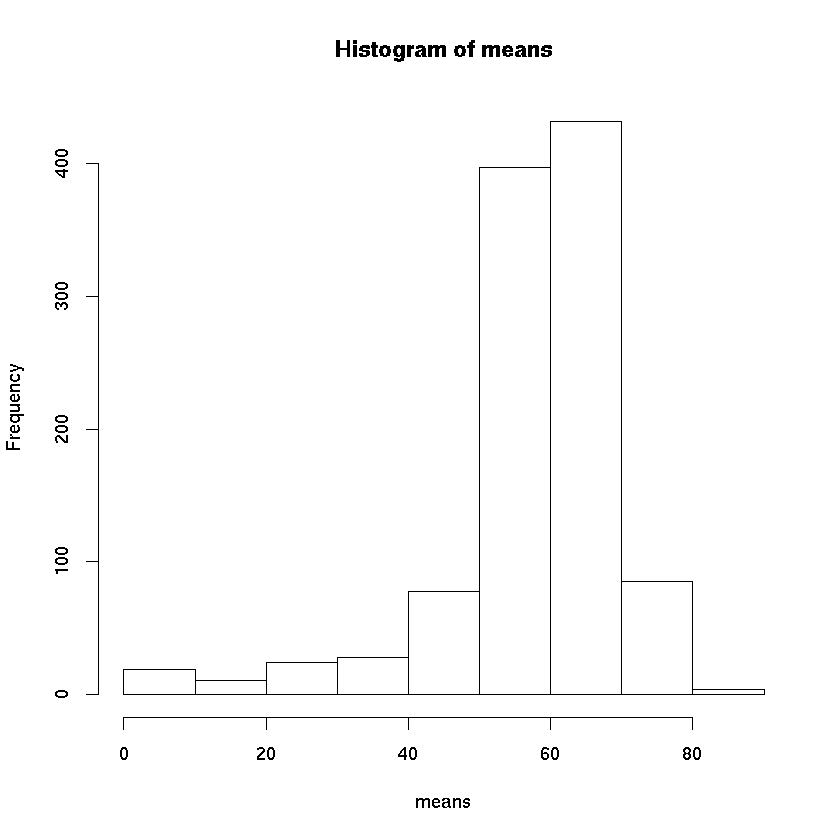

In [147]:
means <- apply(data[1:(ncol(data)-4)], 2, mean)
hist(means)

In [148]:
# write.table(data,file = 'Expr_ClinData_marker_normalized.txt',sep = '\t')

In [149]:
data <- data[, -which(names(data) %in% c('sample'))]
data.surv <- data[,c("survive", "vital_status")]
data.immune <- data[,immune.genes]
data.cancer.type <- data$Type

In [150]:
# remove not needed columns
data <- data[, -which(names(data) %in% c("sample","Type","survive", "vital_status", immune.genes))]

In [151]:
head(data)
tail(data)

PFN2,IL32,KRT1,UPP1,KCNE4,FCGR2B,PHLDA2,ERRFI1,IL27RA,EPB41L2,⋯,TNFRSF9,CCL15,TCF7,BOLA1,TPST1,TNFRSF11A,EPHB6,SOCS5,TIMP1,IL15RA
72.81227,69.73231,0.01000,65.18008,57.76470,50.00255,54.81383,66.42077,55.97727,64.63891,⋯,38.96523,0.01000,58.70867,70.76825,64.27177,45.35897,49.43616,64.36710,86.38499,53.16527
70.43614,57.96485,0.01000,64.61409,62.56897,45.85766,54.08568,55.83826,55.02122,63.68281,⋯,40.01601,0.01000,60.15816,66.50065,65.67036,39.91196,42.26542,62.48327,81.13045,58.84041
68.05602,73.62437,0.01000,64.54972,70.01581,44.23138,48.14446,63.14341,59.08755,53.53226,⋯,40.89978,0.01000,51.62615,64.79117,64.25808,44.44828,43.09724,60.30762,94.12500,50.98794
68.10270,68.15900,0.01000,61.89079,57.34830,41.43827,52.08672,68.59607,60.35171,53.06598,⋯,39.58144,0.01000,53.46163,66.38530,63.78681,46.03283,52.83650,57.32118,95.83271,53.42827
71.13905,59.93020,0.01000,61.00816,57.72134,56.10036,46.94127,76.30807,59.83182,64.74360,⋯,31.24826,41.68823,37.85671,69.72690,68.86331,51.19559,48.18511,64.34909,83.72757,57.10667
71.70308,69.35128,34.19906,65.93097,57.08488,49.10884,52.24391,61.07338,60.10353,58.10287,⋯,37.08590,0.01000,53.13061,71.12095,67.36600,41.67274,48.02226,60.87709,74.54042,55.49380


,PFN2,IL32,KRT1,UPP1,KCNE4,FCGR2B,PHLDA2,ERRFI1,IL27RA,EPB41L2,⋯,TNFRSF9,CCL15,TCF7,BOLA1,TPST1,TNFRSF11A,EPHB6,SOCS5,TIMP1,IL15RA
10907,73.35664,57.82336,0.01000,56.40781,69.02038,41.50187,57.35474,53.07918,49.49002,60.80522,⋯,39.57300,0.01000,55.49689,68.27627,66.60723,43.33364,51.53256,62.34988,79.03094,51.02353
10908,70.40059,52.25944,30.30371,58.18553,57.89676,41.61768,65.80621,59.62312,47.86389,69.00530,⋯,41.52645,29.14052,54.46330,62.88099,59.98646,43.28981,63.64039,59.27705,77.04321,46.51656
10909,73.20467,55.47350,0.01000,56.20222,69.98971,52.96650,72.15636,55.83987,53.89959,65.96412,⋯,0.01000,0.01000,65.53950,70.14133,64.73807,40.09346,54.42309,62.50101,84.02433,46.45886
10910,68.36156,58.52975,0.01000,60.25700,61.64773,39.89421,72.27743,63.24461,57.41213,62.36383,⋯,26.22473,33.94259,61.60251,68.13858,63.72226,46.80710,54.60825,62.73691,79.11899,48.27695
10911,71.25807,58.23433,42.73589,60.74318,69.10394,40.89603,74.05983,59.01710,54.66041,65.31307,⋯,33.62828,0.01000,66.89054,67.83333,65.19418,40.08093,57.57651,61.95818,86.37476,54.13667
10912,68.29061,58.45811,0.01000,62.59498,78.77484,39.55317,72.75063,58.09257,60.89872,67.71836,⋯,45.35047,0.01000,66.45316,70.52306,66.74656,52.38483,55.64850,62.65790,83.75922,48.94176


In [ ]:
set.seed(50135)
savepath = '/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune_non_norm_surv/'

tr.ind=sample(1:nrow(data),replace = F,size = 0.8*nrow(data))
tmp=setdiff(1:nrow(data),tr.ind)
val.ind=sample(tmp,replace = F,size =0.1*nrow(data))
eval.ind=setdiff(tmp,val.ind)


# features
TrainingData=data[tr.ind,]
TestData=data[val.ind,]
EvalData=data[eval.ind,]
write.table(EvalData,file = paste0(savepath,'EvalData.txt'),sep = '\t', row.names = F, quote = F)
write.table(TestData,file = paste0(savepath,'TestData.txt'),sep = '\t',row.names = F, quote = F)
write.table(TrainingData,file = paste0(savepath,'TrainingData.txt'),sep = '\t',row.names = F, quote = F)

# survival labels
TrainingData=data.surv[tr.ind,]
TestData=data.surv[val.ind,]
EvalData=data.surv[eval.ind,]
write.table(EvalData,file = paste0(savepath,'surv.eval.txt'),sep = '\t', row.names = F, quote = F)
write.table(TestData,file = paste0(savepath,'surv.test.txt'),sep = '\t',row.names = F, quote = F)
write.table(TrainingData,file = paste0(savepath,'surv.train..txt'),sep = '\t',row.names = F, quote = F)

# geneset labels
TrainingData=data.immune[tr.ind,]
TestData=data.immune[val.ind,]
EvalData=data.immune[eval.ind,]
write.table(EvalData,file = paste0(savepath,'immune.genes.eval.txt'),sep = '\t', row.names = F, quote = F)
write.table(TestData,file = paste0(savepath,'immune.genes.test.txt'),sep = '\t',row.names = F, quote = F)
write.table(TrainingData,file = paste0(savepath,'immune.genes.train.txt'),sep = '\t',row.names = F, quote = F)

# cancer types
TrainingData=data.cancer.type[tr.ind]
TestData=data.cancer.type[val.ind]
EvalData=data.cancer.type[eval.ind]
write.table(EvalData,file = paste0(savepath,'cancer.type.eval.txt'),sep = '\t', row.names = F, quote = F)
write.table(TestData,file = paste0(savepath,'cancer.type.test.txt'),sep = '\t',row.names = F, quote = F)
write.table(TrainingData,file = paste0(savepath,'cancer.type.train.txt'),sep = '\t',row.names = F, quote = F)

# write out geneset used
genes <- colnames(data)
genes <- genes[1:(length(genes) -2)]
write.table(genes, file=paste0(savepath,'geneset.txt'),row.names = F, quote = F)